In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.models import Model

np.random.seed(123)
tf.random.set_seed (123)

In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

File ‘airline_passengers.csv’ already there; not retrieving.



In [ ]:
df = pd.read_csv('airline_passengers.csv', index_col = 'Month', parse_dates = True)
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [ ]:
df['LogPassengers']= np.log(df['Passengers'])

In [ ]:
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [ ]:
# Boolean series to index rows

train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [ ]:
df['DiffLogPassengers'] = df['LogPassengers'].diff()

In [ ]:
# Make supervised dataset

series = df['DiffLogPassengers'].dropna().to_numpy()

T = 10
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (133, 10, 1) Y.shape (133,)


In [ ]:
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

## CNN

In [ ]:
# CNN

i = Input(shape = (T, 1))
x = Conv1D(16, 3, activation = 'relu')(i)
x = MaxPooling1D(2)(x)
x = Conv1D(32, 3, activation = 'relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1)(x)
model = Model(i, x)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 8, 16)             64        
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 4, 16)            0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 2, 32)             1568      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_1 (Dense)             (None, 1)                 33  

In [ ]:
model.compile(loss = 'mse', optimizer = 'adam')

In [ ]:
r = model.fit(Xtrain, Ytrain, epochs = 100, validation_data = (Xtest, Ytest))

Epoch 1/100
4/4 [==============================] - 1s 49ms/step - loss: 0.0110 - val_loss: 0.0112
Epoch 2/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0102 - val_loss: 0.0109
Epoch 3/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0097 - val_loss: 0.0105
Epoch 4/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0093 - val_loss: 0.0100
Epoch 5/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0089 - val_loss: 0.0097
Epoch 6/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0086 - val_loss: 0.0094
Epoch 7/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0081 - val_loss: 0.0091
Epoch 8/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0077 - val_loss: 0.0089
Epoch 9/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0074 - val_loss: 0.0086
Epoch 10/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0071 - val_loss: 0.0083
Epoch 11/100
4/4 [====

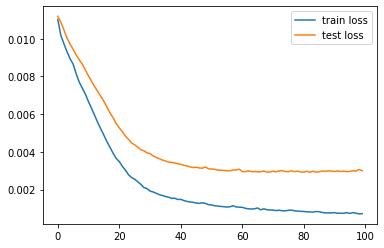

In [ ]:
plt.plot(r.history['loss'], label = 'train loss')
plt.plot(r.history['val_loss'], label = 'test loss')
plt.legend();

In [ ]:
train_idx[:T+1] = False # first T+1 values are not predictable

In [ ]:
Ptrain = model.predict(Xtrain).flatten()
Ptest = model.predict(Xtest).flatten()

In [ ]:
# Store diff predictions

df.loc[train_idx, 'Diff Train Prediction'] = Ptrain
df.loc[test_idx, 'Diff Test Prediction'] = Ptest

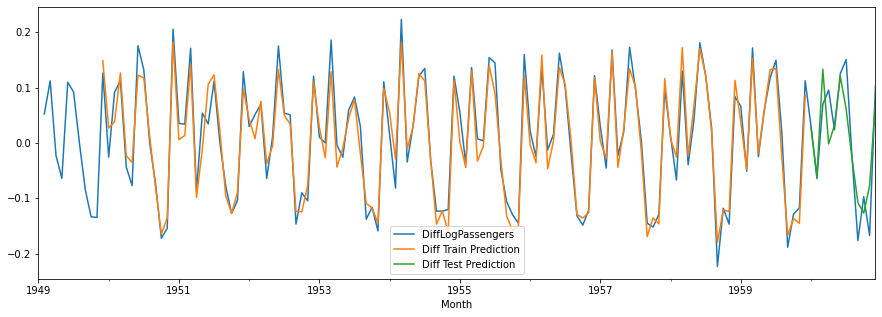

In [ ]:
cols = ['DiffLogPassengers', 'Diff Train Prediction', 'Diff Test Prediction']
df[cols].plot(figsize = (15, 5));

In [ ]:
# Compute un-differenced predictions

df['ShiftLogPassengers'] = df['LogPassengers'].shift(1)
prev = df['ShiftLogPassengers']

In [ ]:
# Last known train value
last_train = train.iloc[-1]['LogPassengers']

## 1-step

In [ ]:
# 1-step forecast

df.loc[train_idx, '1step_train'] = prev[train_idx] + Ptrain
df.loc[test_idx, '1step_test'] = prev[test_idx] + Ptest

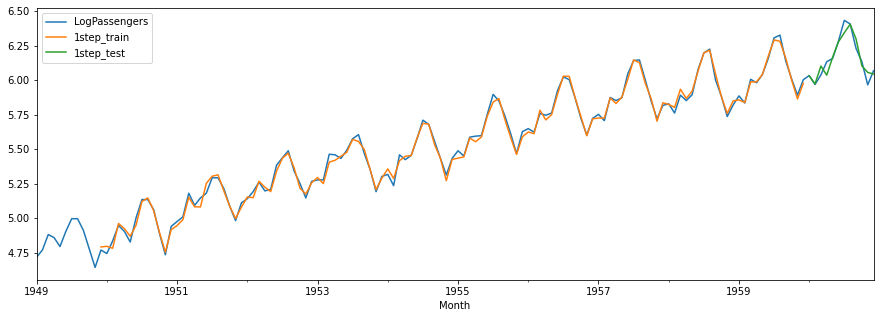

In [ ]:
# Plot 1-step

df[['LogPassengers', '1step_train', '1step_test']].plot(figsize = (15, 5));

## Multistep

In [ ]:
# Multi-step forecast 

multistep_predictions = []

# First test input

last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
  # last_x array reshaped because sklearn only accepts 2D input
  p = model(last_x.reshape(1, -1))[0]

  # Update predictions list
  multistep_predictions.append(p)

  # Make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

In [ ]:
# Save multi-step forecast to the dataframe

df.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions)

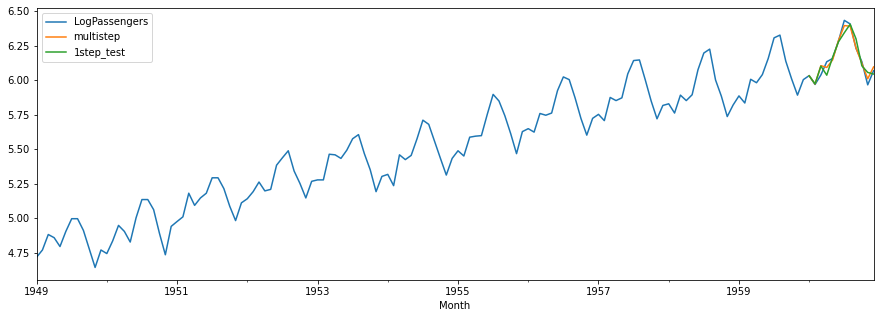

In [ ]:
# Plot 1-step and multistep

df[['LogPassengers', 'multistep', '1step_test']].plot(figsize = (15, 5));

## Multi output

In [ ]:
# Make multi-output supervised dataset

Tx = T      # number of timesteps in the input
Ty = Ntest  # number of timesteps in the output
X = []
Y = []

for t in range(len(series) - Tx - Ty + 1):
  x = series[t:t+Tx]
  X.append(x)
  y = series[t+Tx:t+Tx+Ty]
  Y.append(y)

X = np.array(X).reshape(-1, Tx)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (122, 10) Y.shape (122, 12)


In [ ]:
# Split into train and test

Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [ ]:
# CNN

i = Input(shape = (Tx, 1))
x = Conv1D(16, 3, activation = 'relu')(i)
x = MaxPooling1D(2)(x)
x = Conv1D(32, 3, activation = 'relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(Ty)(x)
model = Model(i, x)

In [ ]:
model.compile(loss = 'mse', optimizer = 'adam')

In [ ]:
r = model.fit(Xtrain_m, Ytrain_m, epochs = 200, validation_data = (Xtest_m, Ytest_m))

Epoch 1/200
4/4 [==============================] - 1s 54ms/step - loss: 0.0122 - val_loss: 0.0122
Epoch 2/200
4/4 [==============================] - 0s 9ms/step - loss: 0.0116 - val_loss: 0.0113
Epoch 3/200
4/4 [==============================] - 0s 12ms/step - loss: 0.0113 - val_loss: 0.0107
Epoch 4/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0110 - val_loss: 0.0103
Epoch 5/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0108 - val_loss: 0.0099
Epoch 6/200
4/4 [==============================] - 0s 12ms/step - loss: 0.0105 - val_loss: 0.0094
Epoch 7/200
4/4 [==============================] - 0s 12ms/step - loss: 0.0103 - val_loss: 0.0090
Epoch 8/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0101 - val_loss: 0.0084
Epoch 9/200
4/4 [==============================] - 0s 9ms/step - loss: 0.0099 - val_loss: 0.0079
Epoch 10/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0097 - val_loss: 0.0075
Epoch 11/200
4/4 [===

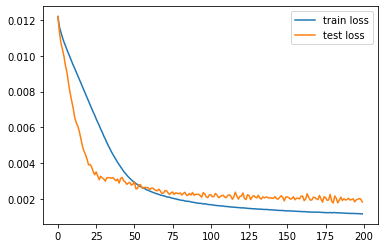

In [ ]:
plt.plot(r.history['loss'], label = 'train loss')
plt.plot(r.history['val_loss'], label = 'test loss')
plt.legend();

In [ ]:
Ptrain = model.predict(Xtrain_m)
Ptest = model.predict(Xtest_m)

In [ ]:
Ptrain = model.predict(Xtrain_m)
Ptest = model.predict(Xtest_m)

In [ ]:
Ptrain.shape, Ptest.shape

((121, 12), (1, 12))

In [ ]:
Ptrain = Ptrain[:,0]
Ptest = Ptest[0]

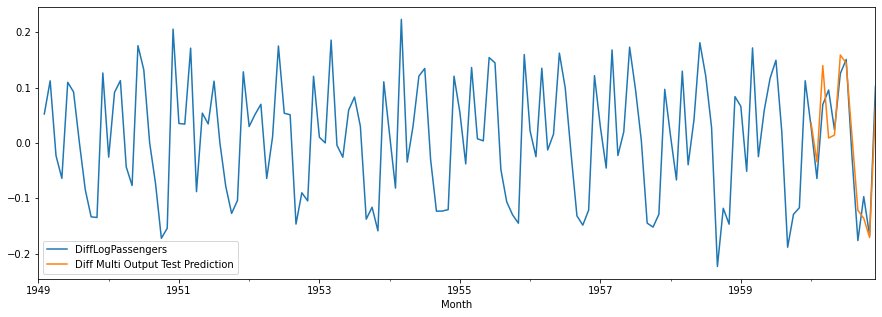

In [ ]:
df.loc[test_idx, 'Diff Multi Output Test Prediction'] = Ptest
df[['DiffLogPassengers', 'Diff Multi Output Test Prediction']].plot(figsize = (15, 5));

In [ ]:
# Save output to dataframe

df.loc[test_idx, 'multioutput'] = last_train + np.cumsum(Ptest)

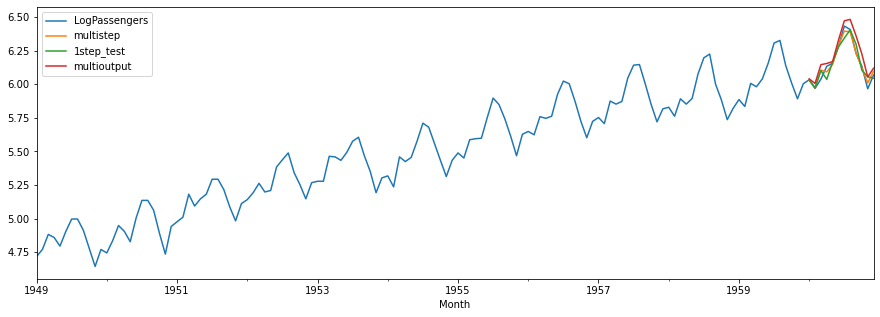

In [ ]:
df[['LogPassengers', 'multistep', '1step_test', 'multioutput']].plot(figsize = (15, 5));

In [ ]:
# Use different metric

# MAPE
test_log_pass = df.iloc[-Ntest:]['LogPassengers']

mape1 = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx, 'multistep'])
print('Multi-step MAPE:', mape1)

mape2 = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx, 'multioutput'])
print('Multi-output MAPE:', mape2)

Multi-step MAPE: 0.003642729631224577
Multi-output MAPE: 0.009568176619890111
